In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%aimport flange
import importlib
import networkx as nx

In [24]:
def draw(g):
    pos=nx.spring_layout(g)
    nx.draw(g, pos=pos)
    nx.draw_networkx_labels(g, pos=pos)


In [25]:
class inside(flange.FlangeTree):
    """Given a graph and a selector, returns a list of links that make up the min cut
    
    TODO: Graph must have a clear "side-id-ness" to it to work...  
          ###Source and ###Sink cannot both link to the same node.
    """
    def __init__(self, selector):
        self.selector=selector

    def __call__(self, graph):
        selector = lambda x: self.selector(x, graph)
        nodes = list(filter(selector, graph.nodes())) ## TODO -- More complex query here
        synth = graph.subgraph(nodes) ## Get the subgraph indicated by the selector
        nx.set_edge_attributes(synth, 'capacity', 1)

        print("all nodes", nodes)
        print("init synth nodes:", synth.nodes())
        print("init synth edges:", synth.edges())
        outbound = list(graph.out_edges_iter(nodes))
        inbound = list(graph.in_edges_iter(nodes))
        print(inbound)
        print(outbound)

        src = "##SOURCE##"
        synth.add_node(src)
        for edge in inbound:
            if not synth.has_edge(*edge):
                synth.add_edge(src, edge[1], capacity=10)

        sink = "##SINK##"
        synth.add_node(sink)
        for edge in outbound:
            if not synth.has_edge(*edge):
                synth.add_edge(edge[0], sink, capacity=10)

        draw(synth)
        print("synth edges:", synth.edges())
        cut_value, partition = nx.minimum_cut(synth, s=src, t=sink, capacity='capacity')
        reachable, non_reachable = partition

        cutset = set()
        for u, nbrs in ((n, synth[n]) for n in reachable):
            cutset.update((u, v) for v in nbrs if v in non_reachable)
            cut_value == sum(synth.edge[u][v]['capacity'] for (u, v) in cutset)


        return cutset

all nodes ['port2', 'port3', 'port1']
init synth nodes: ['port2', 'port3', 'port1']
init synth edges: [('port2', 'port3'), ('port1', 'port2')]
[('port1', 'port2'), ('port2', 'port3'), ('port4', 'port1')]
[('port2', 'port3'), ('port3', 'port4'), ('port1', 'port2')]
synth edges: [('port2', 'port3'), ('port3', '##SINK##'), ('##SOURCE##', 'port1'), ('port1', 'port2')]


{('port2', 'port3')}

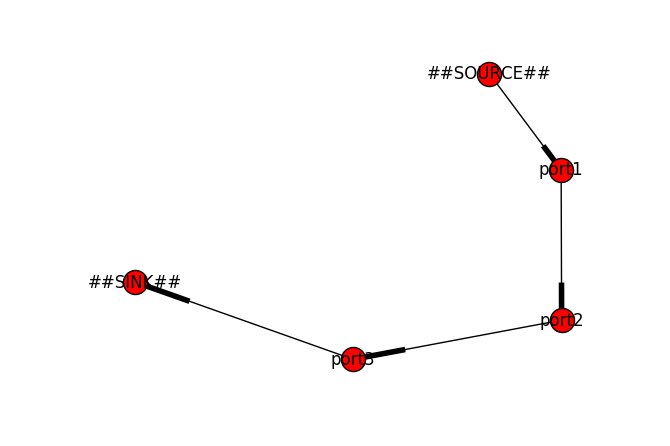

In [29]:
i = inside(lambda x,g: int(g.node[x]["id"][-1]) < 4)(flange.graph("ring")())
r = {(e[0], e[1]) for e in i}
r